In [1]:
import os
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import cv2
import sys
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt


## Read Data

In [2]:
import os
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
import mahotas
import scipy.stats
import random

image_dir = "./Vehicle Data"
categories = ["Seden", "Pickup", "SUV", "Hatchback", "Other"]
all_images = []
labels = []

for category in categories:
    category_dir = os.path.join(image_dir, category)
    category_images = [os.path.join(category_dir, filename) for filename in os.listdir(category_dir)]
    all_images.extend(category_images)
    labels.extend([category] * len(category_images))

## Train Test Split¶

In [3]:
# Train-Test plit
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

new_size = (256, 256)
train_features = [] 
val_features = []
test_features = []

## Feauture Extractions

In [4]:
def extract_hog_features(image):
    hog_features = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
    return hog_features

def extract_color_histogram(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_s = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    color_hist = np.concatenate((hist_h, hist_s, hist_v), axis=None)
    return color_hist

def extract_lbp_features(image):
    lbp_image = local_binary_pattern(image, P=8, R=1, method='default')
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, 10), range=(0, 10))
    return hist

def extract_gabor_features(image):
    filters = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        kernel = cv2.getGaborKernel((21, 21), 5.0, theta, 10.0, 1, 0, ktype=cv2.CV_32F)
        filters.append(kernel)
    feats = []
    for kernel in filters:
        filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        hist = cv2.calcHist([filtered], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        feats.extend(hist)
    return feats

def extract_lpq_features(image):
    lpq = mahotas.features.lbp(image, 8, 1, ignore_zeros=False)
    hist, _ = np.histogram(lpq.ravel(), bins=np.arange(0, 10), range=(0, 10))
    return hist

def extract_features(image):
    resize_image = cv2.resize(image, new_size)
    gray_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2GRAY)

    hog_features = extract_hog_features(gray_image)
    color_hist = extract_color_histogram(resize_image)
    lbp_features = extract_lbp_features(gray_image)
    gabor_features = extract_gabor_features(gray_image)
    lpq_features = extract_lpq_features(gray_image)
    
    features = np.concatenate((hog_features, color_hist, lbp_features, gabor_features, lpq_features), axis=None)
    
    return features

## Data Augmentation

In [5]:
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []
    for image, label in zip(images, labels):
        # Brightness
        brightness_factor = random.uniform(0.5, 2.0)  # Adjust brightness between 0.5 and 2.0
        augmented_image = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)

        # Rotation 
        angle = random.randint(-15, 15)  # Rotate between -15 and 15 degrees
        rows, cols = augmented_image.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        augmented_image = cv2.warpAffine(augmented_image, rotation_matrix, (cols, rows))

        augmented_images.append(augmented_image)
        augmented_labels.append(label)
    return augmented_images, augmented_labels

## Feature Extractions 

### Apply  in original train with augmented

In [6]:
for image_path in train_images:
    train_features.append(extract_features(cv2.imread(image_path)))

augmented_train_images, augmented_train_labels = augment_data([cv2.imread(image_path) for image_path in train_images], train_labels)

for image, label in zip(augmented_train_images, augmented_train_labels):
    train_features.append(extract_features(image))
    train_labels.append(label)

train_labels_augmented = np.array(train_labels + augmented_train_labels)
train_features = np.array(train_features)


for image_path in test_images:
    test_features.append(extract_features(cv2.imread(image_path)))

test_features = np.array(test_features)

train_labels = np.array(train_labels)

test_labels = np.array(test_labels)

print("Train Features Shape:", train_features.shape)
print("Train Labels Shape:", train_labels.shape)

Train Features Shape: (7668, 3858)
Train Labels Shape: (7668,)


In [7]:
print("TestFeatures Shape:", test_features.shape)
print("Test Labels Shape:", test_labels.shape)

TestFeatures Shape: (959, 3858)
Test Labels Shape: (959,)


In [8]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [9]:
fold = 1
for train_index, test_index in kf.split(train_features, train_labels):
    train_data_count = len(train_index)
    test_data_count = len(test_index)
    
    print(f"Fold {fold}:")
    print(f"Number of image for training set: {train_data_count}")
    print(f"Number of image for validation set: {test_data_count}\n")
    
    fold += 1

Fold 1:
Number of image for training set: 6901
Number of image for validation set: 767

Fold 2:
Number of image for training set: 6901
Number of image for validation set: 767

Fold 3:
Number of image for training set: 6901
Number of image for validation set: 767

Fold 4:
Number of image for training set: 6901
Number of image for validation set: 767

Fold 5:
Number of image for training set: 6901
Number of image for validation set: 767

Fold 6:
Number of image for training set: 6901
Number of image for validation set: 767

Fold 7:
Number of image for training set: 6901
Number of image for validation set: 767

Fold 8:
Number of image for training set: 6901
Number of image for validation set: 767

Fold 9:
Number of image for training set: 6902
Number of image for validation set: 766

Fold 10:
Number of image for training set: 6902
Number of image for validation set: 766



## Comparison train data with Data Augmentations

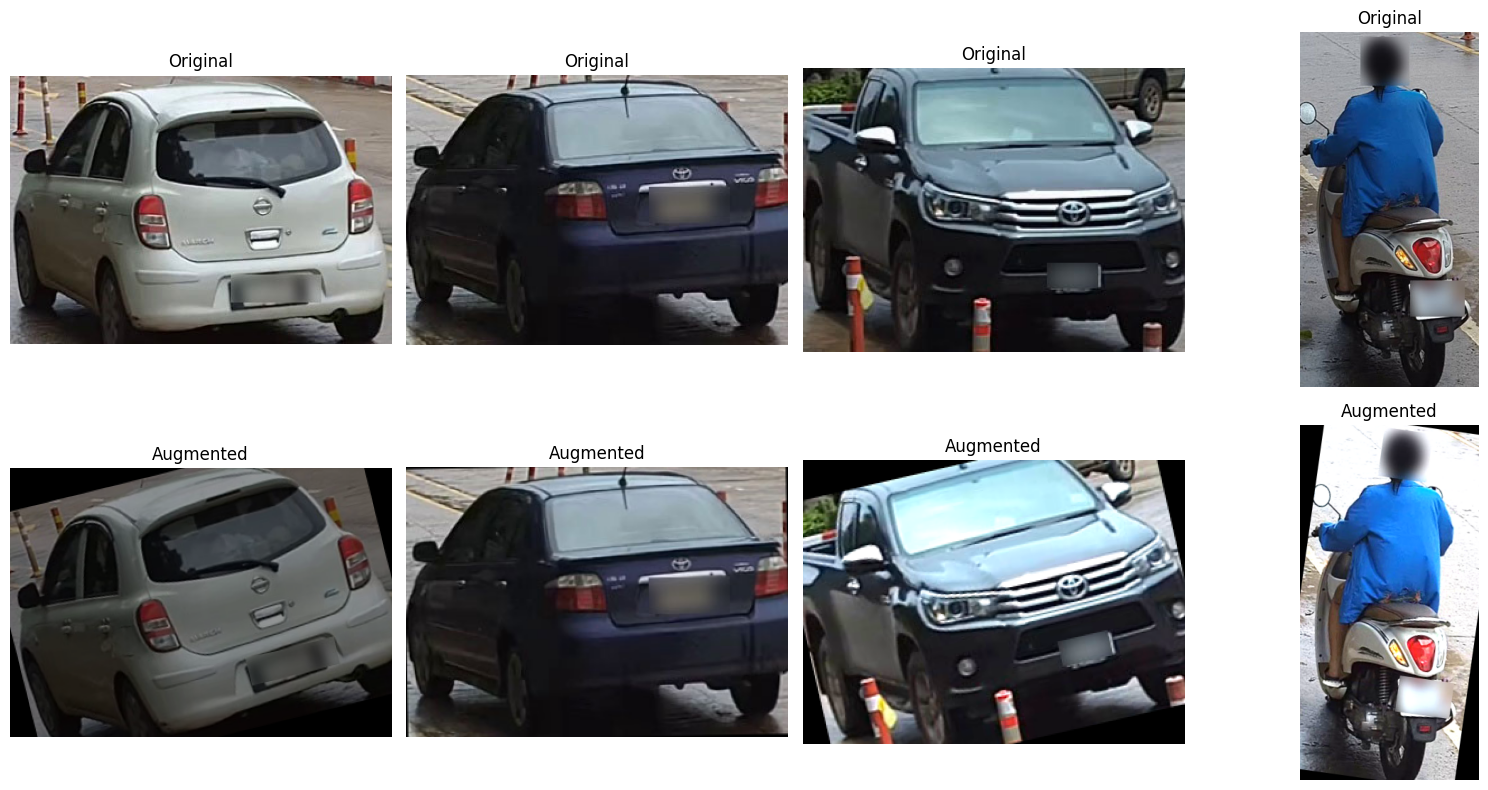

In [10]:
import matplotlib.pyplot as plt

# Select 4 random indices from the original training set
original_indices = np.random.choice(len(train_images), 4, replace=False)

# Select 4 corresponding augmented images
augmented_images = [augmented_train_images[i] for i in original_indices]

# Display original and augmented images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, idx in enumerate(original_indices):
    original_image = cv2.imread(train_images[idx])
    augmented_image = augmented_images[i]

    axes[0, i].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    axes[1, i].imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    axes[1, i].set_title("Augmented")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Machine Learning

### Set Hyperparameter Tuning with 10-fold validation

In [13]:
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly']
}

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1,2]
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

### Apply Support vector machine, K-nearest neighbour, Random Forest, Ensemble Learning (Voting and Stacking)

In [14]:
svc_grid = GridSearchCV(SVC(), svc_params, cv=kf)
svc_grid.fit(train_features, train_labels)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly']})

In [15]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=kf)
knn_grid.fit(train_features, train_labels)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                    

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [16]:
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=kf)
rf_grid.fit(train_features, train_labels)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]})

In [17]:
voting_classifier = VotingClassifier(estimators=[
    ('svc', svc_grid.best_estimator_),
    ('knn', knn_grid.best_estimator_),
    ('rf', rf_grid.best_estimator_)
], voting='hard')
voting_classifier.fit(train_features, train_labels)

VotingClassifier(estimators=[('svc', SVC(C=10)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=3, p=1,
                                                   weights='distance')),
                             ('rf', RandomForestClassifier(n_estimators=200))])

In [18]:
stacking_classifier = StackingClassifier(estimators=[
    ('svc', svc_grid.best_estimator_),
    ('knn', knn_grid.best_estimator_),
    ('rf', rf_grid.best_estimator_)
], final_estimator=LogisticRegression())

stacking_classifier.fit(train_features, train_labels)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('svc', SVC(C=10)),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=3, p=1,
                                                     weights='distance')),
                               ('rf',
                                RandomForestClassifier(n_estimators=200))],
                   final_estimator=LogisticRegression())

In [19]:
voting_scores = cross_val_score(voting_classifier, train_features, train_labels, cv=10)
stacking_scores = cross_val_score(stacking_classifier, train_features, train_labels, cv=10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

### Prediction and Evaluation Peformance Metrics Machine Learning

Metrics for SVM:
Accuracy: 0.940563086548488
Sensitivity (Recall): {'Seden': 0.8372093023255814, 'Pickup': 0.9083333333333333, 'SUV': 0.9966996699669967, 'Hatchback': 0.9477611940298507, 'Other': 0.9377289377289377}
Specificity: {'Seden': 0.9891566265060241, 'Pickup': 1.0, 'SUV': 0.961890243902439, 'Hatchback': 0.9903030303030304, 'Other': 0.978134110787172}
Classification Report:
              precision    recall  f1-score   support

   Hatchback       0.92      0.84      0.88       129
       Other       1.00      0.91      0.95       120
      Pickup       0.92      1.00      0.96       303
         SUV       0.94      0.95      0.94       134
       Seden       0.94      0.94      0.94       273

    accuracy                           0.94       959
   macro avg       0.95      0.93      0.93       959
weighted avg       0.94      0.94      0.94       959



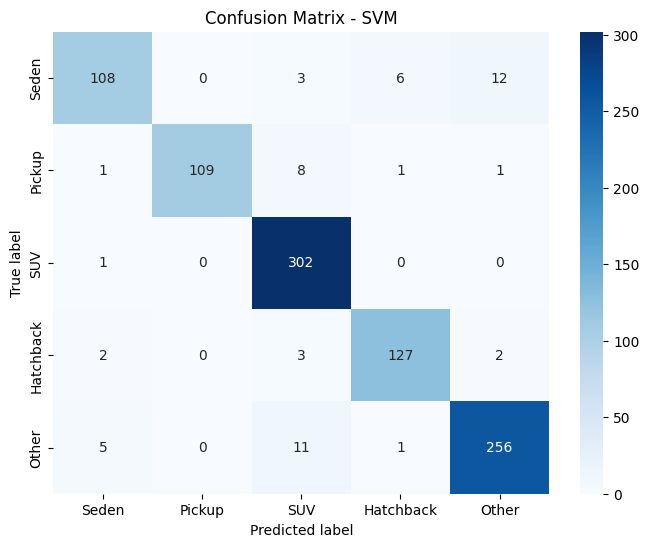

Metrics for KNN:
Accuracy: 0.9812304483837331
Sensitivity (Recall): {'Seden': 0.9689922480620154, 'Pickup': 0.9, 'SUV': 1.0, 'Hatchback': 1.0, 'Other': 0.9926739926739927}
Specificity: {'Seden': 0.9987951807228915, 'Pickup': 1.0, 'SUV': 0.9908536585365854, 'Hatchback': 0.9927272727272727, 'Other': 0.9927113702623906}
Classification Report:
              precision    recall  f1-score   support

   Hatchback       0.99      0.97      0.98       129
       Other       1.00      0.90      0.95       120
      Pickup       0.98      1.00      0.99       303
         SUV       0.96      1.00      0.98       134
       Seden       0.98      0.99      0.99       273

    accuracy                           0.98       959
   macro avg       0.98      0.97      0.98       959
weighted avg       0.98      0.98      0.98       959



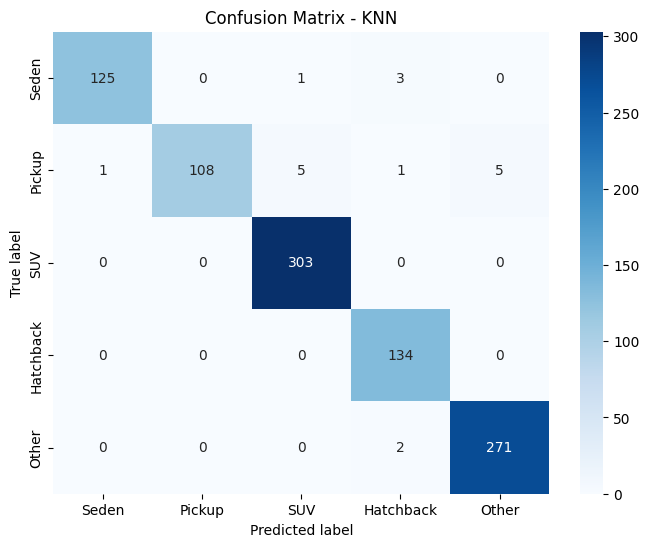

Metrics for Random Forest:
Accuracy: 0.9812304483837331
Sensitivity (Recall): {'Seden': 0.9612403100775194, 'Pickup': 0.9166666666666666, 'SUV': 1.0, 'Hatchback': 1.0, 'Other': 0.989010989010989}
Specificity: {'Seden': 1.0, 'Pickup': 1.0, 'SUV': 0.975609756097561, 'Hatchback': 0.9987878787878788, 'Other': 0.9985422740524781}
Classification Report:
              precision    recall  f1-score   support

   Hatchback       1.00      0.96      0.98       129
       Other       1.00      0.92      0.96       120
      Pickup       0.95      1.00      0.97       303
         SUV       0.99      1.00      1.00       134
       Seden       1.00      0.99      0.99       273

    accuracy                           0.98       959
   macro avg       0.99      0.97      0.98       959
weighted avg       0.98      0.98      0.98       959



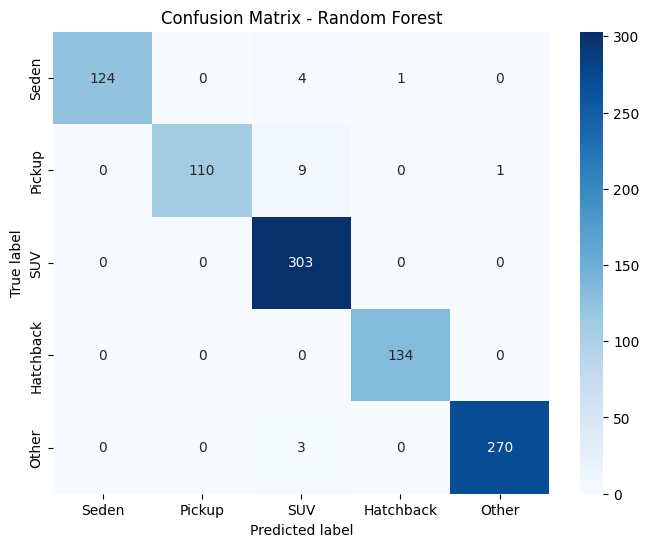

Metrics for Voting Classifier:
Accuracy: 0.9822732012513035
Sensitivity (Recall): {'Seden': 0.9612403100775194, 'Pickup': 0.925, 'SUV': 1.0, 'Hatchback': 1.0, 'Other': 0.989010989010989}
Specificity: {'Seden': 1.0, 'Pickup': 1.0, 'SUV': 0.9801829268292683, 'Hatchback': 0.9963636363636363, 'Other': 0.9985422740524781}
Classification Report:
              precision    recall  f1-score   support

   Hatchback       1.00      0.96      0.98       129
       Other       1.00      0.93      0.96       120
      Pickup       0.96      1.00      0.98       303
         SUV       0.98      1.00      0.99       134
       Seden       1.00      0.99      0.99       273

    accuracy                           0.98       959
   macro avg       0.99      0.98      0.98       959
weighted avg       0.98      0.98      0.98       959



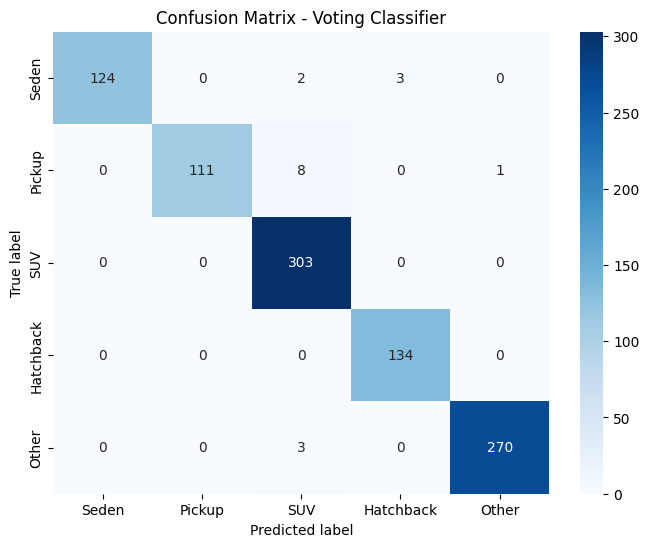

Metrics for Stacking Classifier:
Accuracy: 0.9874869655891554
Sensitivity (Recall): {'Seden': 0.9612403100775194, 'Pickup': 0.9416666666666667, 'SUV': 1.0, 'Hatchback': 1.0, 'Other': 1.0}
Specificity: {'Seden': 1.0, 'Pickup': 1.0, 'SUV': 0.9908536585365854, 'Hatchback': 0.9963636363636363, 'Other': 0.9956268221574344}
Classification Report:
              precision    recall  f1-score   support

   Hatchback       1.00      0.96      0.98       129
       Other       1.00      0.94      0.97       120
      Pickup       0.98      1.00      0.99       303
         SUV       0.98      1.00      0.99       134
       Seden       0.99      1.00      0.99       273

    accuracy                           0.99       959
   macro avg       0.99      0.98      0.98       959
weighted avg       0.99      0.99      0.99       959



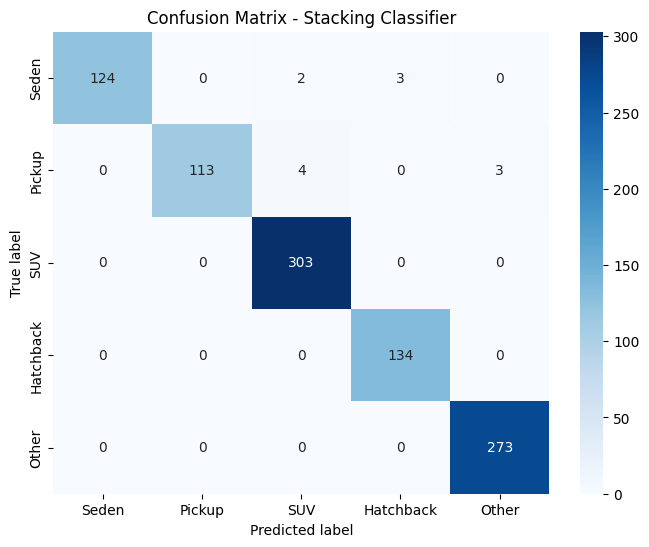

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_classifier(classifier, classifier_name, test_features, test_labels):
    predictions = classifier.predict(test_features)
    acc = accuracy_score(test_labels, predictions)
    conf_matrix = confusion_matrix(test_labels, predictions)
    cls_report = classification_report(test_labels, predictions)
    
    true_positives = np.diag(conf_matrix)
    false_positives = np.sum(conf_matrix, axis=0) - true_positives
    false_negatives = np.sum(conf_matrix, axis=1) - true_positives
    true_negatives = np.sum(conf_matrix) - (true_positives + false_positives + false_negatives)

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    sensitivity_dict = {categories[i]: sensitivity[i] for i in range(len(categories))}
    specificity_dict = {categories[i]: specificity[i] for i in range(len(categories))}

    print(f"Metrics for {classifier_name}:")
    print("Accuracy:", acc)
    print("Sensitivity (Recall):", sensitivity_dict)
    print("Specificity:", specificity_dict)
    print("Classification Report:")
    print(cls_report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
    plt.title(f"Confusion Matrix - {classifier_name}")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

classifiers = [svc_grid.best_estimator_, knn_grid.best_estimator_, rf_grid.best_estimator_, voting_classifier, stacking_classifier]
classifier_names = ['SVM', 'KNN', 'Random Forest', 'Voting Classifier', 'Stacking Classifier']

for classifier, classifier_name in zip(classifiers, classifier_names):
    evaluate_classifier(classifier, classifier_name, test_features, test_labels)

## Deep Learning

## Read Dataset and Split Train Test Data

In [ ]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split

image_dir = "./Vehicle Data"
categories = ["Seden", "Pickup", "SUV", "Hatchback", "Other"]
batch_size = 32
img_height = 100
img_width = 100
num_classes = len(categories)
num_folds = 10
test_size = 0.2 


train_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels="inferred",
    label_mode="int",
    class_names=categories,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels="inferred",
    label_mode="int",
    class_names=categories,
)


## Split Dataset ; Train, Validation, Test Dataset

In [ ]:
train_val_images = []
train_val_labels = []
for images, labels in train_val_data:
    train_val_images.append(images.numpy())
    train_val_labels.append(labels.numpy())
train_val_images = np.vstack(train_val_images)
train_val_labels = np.concatenate(train_val_labels)

test_images = []
test_labels = []
for images, labels in test_data:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.vstack(test_images)
test_labels = np.concatenate(test_labels)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.2, random_state=42
)

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

train_images_augmented = data_augmentation(train_images)

train_images_combined = np.concatenate([train_images, train_images_augmented])
train_labels_combined = np.concatenate([train_labels, train_labels])


AUTOTUNE = tf.data.AUTOTUNE
train_data = tf.data.Dataset.from_tensor_slices((train_images_combined, train_labels_combined)).prefetch(buffer_size=AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).prefetch(buffer_size=AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).prefetch(buffer_size=AUTOTUNE)

## Fully connected neural network With Hyperparamter Tuning

In [ ]:
def build_model(learning_rate=0.001, optimizer='adam', dropout_rate=0.2, hidden_units=128):
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
        
    model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Flatten(),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes)
    ])
    model.compile(optimizer=opt,
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model


param_grid = {
    'hidden_units': [128, 256],
    'learning_rate': [0.001, 0.01],
    'optimizer': ['adam']
}

model = keras.wrappers.scikit_learn.KerasClassifier(build_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=kf, verbose=1)
grid_search.fit(train_images_combined, train_labels_combined, validation_data=(val_images, val_labels), epochs = 10)

print("Best hyperparameters found: ", grid_search.best_params_)

best_model_mlp = grid_search.best_estimator_
test_loss, test_accuracy = best_model_mlp.model.evaluate(test_images, test_labels)
print("Test accuracy of the best model:", test_accuracy)

In [ ]:
def evaluate_classifier(classifier, classifier_name, test_features, test_labels):
    predictions = classifier.predict(test_features)
    acc = accuracy_score(test_labels, predictions)
    conf_matrix = confusion_matrix(test_labels, predictions)
    cls_report = classification_report(test_labels, predictions)
    
    print(f"Metrics for {classifier_name}:")
    print("Accuracy:", acc)
    print("Classification Report:")
    print(cls_report)

    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
    plt.title(f"Confusion Matrix - {classifier_name}")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

classifiers = [best_model_mlp]
classifier_names = ['Fully connected neural network']


for classifier, classifier_name in zip(classifiers, classifier_names):
    evaluate_classifier(classifier, classifier_name, test_images, test_labels)

## CNN With Hyperparamter Tuning

In [ ]:
def build_model(learning_rate=0.001, optimizer='adam', dropout_rate=0.2):
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
        
    model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes)
    ])
    model.compile(optimizer=opt,
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

param_grid = {
    'learning_rate': [0.001, 0.01],
    'optimizer': ['adam']
}

model = keras.wrappers.scikit_learn.KerasClassifier(build_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=kf, verbose=1)
grid_search.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs = 5)

print("Best hyperparameters found: ", grid_search.best_params_)

best_model_cnn = grid_search.best_estimator_
test_loss, test_accuracy = best_model_cnn.model.evaluate(test_images, test_labels)
print("Test accuracy of the best model CNN:", test_accuracy)

## Evaluation CNN and Fully connected neural network

In [ ]:
def evaluate_classifier(classifier, classifier_name, test_features, test_labels):
    predictions = classifier.predict(test_features)
    acc = accuracy_score(test_labels, predictions)
    conf_matrix = confusion_matrix(test_labels, predictions)
    cls_report = classification_report(test_labels, predictions)
    
    print(f"Metrics for {classifier_name}:")
    print("Accuracy:", acc)
    print("Classification Report:")
    print(cls_report)

    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
    plt.title(f"Confusion Matrix - {classifier_name}")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

classifiers = [best_model_cnn]
classifier_names = ['Convolutional neural network']


for classifier, classifier_name in zip(classifiers, classifier_names):
    evaluate_classifier(classifier, classifier_name, test_images, test_labels)

## Reference 

## The code used in this document is sourced from Python documentation, as well as lecture modules on Big Data Analytics and Modeling, and image processing for data science.
## Sandipan Dey (2018b). Hands-on image processing with Python : expert techniques for advanced image analysis and effective interpretation of image data. Birmingham, Uk: Packt Publishing Ltd.
